In [8]:
import os
import joblib
#import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

In [9]:
import shap

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
model = joblib.load('lgb.pkl')
scaler = joblib.load('scaler.gz')

original_test = pd.read_csv("preprocess_dataset_rl_v1.csv")
test = original_test.sort_values("timestamp")
test = test.drop([col for col in test.columns if col.startswith("source_")], axis=1)
test = test.drop(['mmsi', 'timestamp'], axis=1)
test_pred = model.predict(test)
test_pred = test_pred.round(0)
print(test_pred)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


# SHAP 

In [66]:
# Find the turning point t, which has a different status from t+1 
def find_turning_point(arr):
    turning_list = []
    i=0
    while i < len(arr)-2:
        if arr[i]!=arr[i+1]:
            turning_list.append(i)
        i+=1
    return turning_list

In [65]:
# Find the turning point t, where prediction at t is 0 and prediction at t+1 is 1 
def find_turning_point_from0(arr):
    turning_list = []
    i=0
    while i < len(arr)-2:
        if arr[i]==0 and arr[i+1]==1:
            turning_list.append(i)
        i+=1
    return turning_list

In [61]:
test_readable = pd.read_csv("preprocess_dataset_rl_v1.csv")
test_readable = test_readable.sort_values("timestamp")
test_readable = pd.DataFrame(data=scaler.inverse_transform(test_readable), columns=test_readable.columns)
test_readable.timestamp = pd.to_datetime(test_readable.timestamp, unit='s')
test_readable.timestamp = test_readable.timestamp.apply(lambda x: x.strftime('%Y-%m-%d, %H:%M:%S'))
test_readable['pred'] = test_pred

In [63]:
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(test)

In [64]:
def local_intepret(inx):
    p = int(test_pred[inx])
    c = 1
    print('Sample No.%s is predicted as %s.'%(inx,p))
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[c], shap_values[inx].values[:,c], test.iloc[inx,:].values,
                                           feature_names= test.columns, max_display=15)

In [67]:
find_turning_point(test_pred)

[0, 31, 35, 37, 47, 51, 55, 56, 59, 136, 138, 139]

In [68]:
find_turning_point_from0(test_pred)

[0, 35, 47, 55, 59, 138]

In [69]:
# choose a range to include data points before and after a turning point
start_point = 57
end_point = start_point+6
test_readable[start_point:end_point]

,lat_x,lon_x,course,speed,timestamp,distance_from_shore,distance_from_port,mmsi,doy,dow,...,gear_type_fixed_gear,gear_type_pole_and_line,gear_type_purse_seines,gear_type_trawlers,gear_type_trollers,hemisphere_ns_north,hemisphere_ns_south,hemisphere_ew_east,hemisphere_ew_west,pred
57,48.42167,-125.993977,116.947162,10.5,"2021-04-07, 19:50:00",2614.0,2771.784912,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
58,48.48985,-125.959934,118.356164,12.0,"2021-04-07, 20:11:00",2622.0,2776.608398,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
59,48.42558,-125.968320,30.293542,0.8,"2021-04-07, 21:40:00",2615.0,2771.765625,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
60,48.43167,-125.956639,31.702544,4.0,"2021-04-07, 22:05:00",2615.0,2771.315918,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0
61,48.45442,-125.966323,223.326810,8.1,"2021-04-07, 22:16:00",2617.0,2773.079346,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0
62,48.44796,-125.958037,86.653620,4.6,"2021-04-07, 22:27:00",2617.0,2773.079346,1.682113e+10,97.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0


Sample No.57 is predicted as 0.


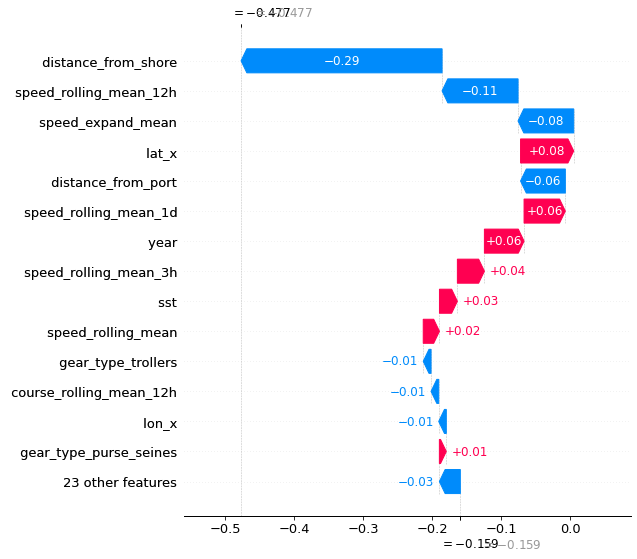

In [70]:
local_intepret(start_point)

Sample No.63 is predicted as 1.


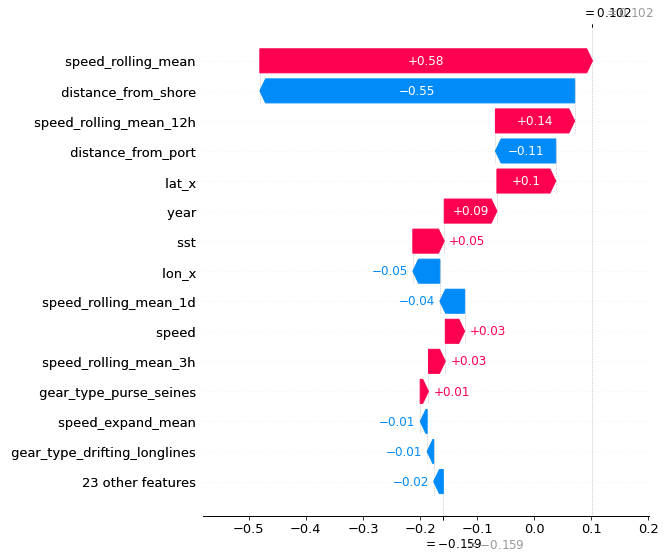

In [71]:
local_intepret(end_point)

# Feature importance from LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

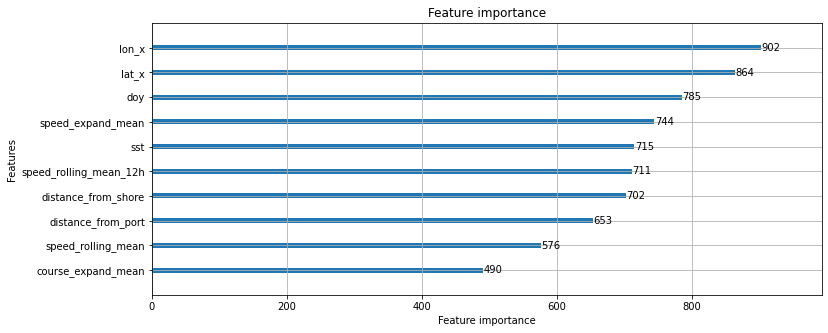

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))
lgb.plot_importance(model, ax=ax, max_num_features=10) 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

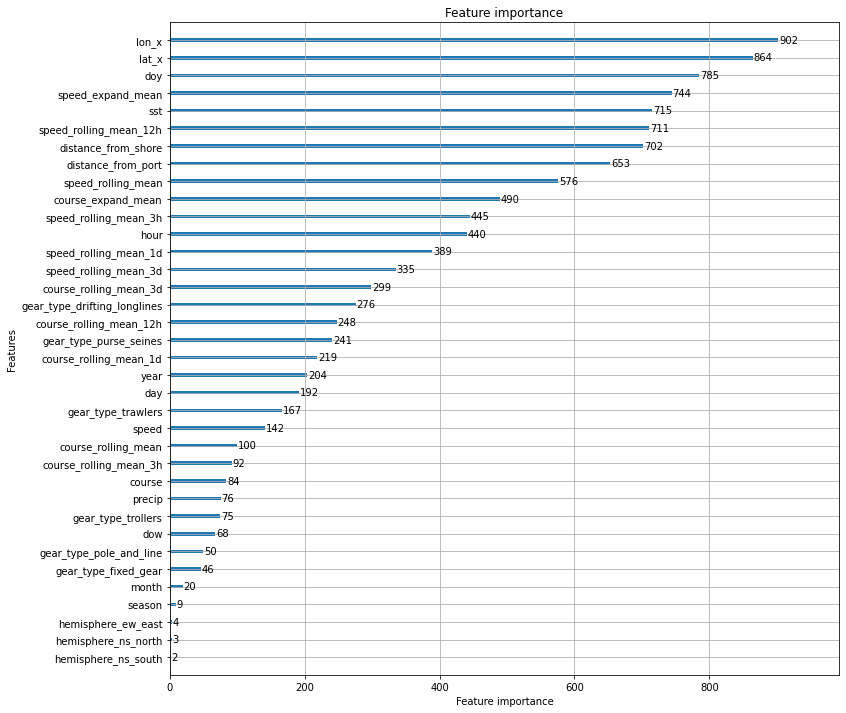

In [73]:
fig, ax = plt.subplots(figsize=(12, 12))
lgb.plot_importance(model, ax=ax)